In [78]:
import os
import sys
import json

import numpy as np
import pandas as pd

import torch
import torchvision

import matplotlib.pyplot as plt
import lightning as L

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

from data_module.data_module import FFTDataModule
from model.enc_classifier_model import AE1DClassifier
from model.AE_model import AECNN1DModel

In [2]:
random_seed = 42
L.seed_everything(random_seed)

Seed set to 42


42

In [6]:
n_epochs = 20000
patience = n_epochs//100

optimizer_param_dict = {
    "Adam": (optim.Adam, {
        "lr": 0.001,
    }),
    "SGD": (optim.SGD, {
        "lr": 0.001,
        "momentum": 0.5,
    }),
}
batch_size = 512
optimizer, optimizer_param = optimizer_param_dict["Adam"]
dataset_path = "/nfs/ksdata/tran/HAR_AE/dataset/processed_concat_data"
AE1D_ckpt_path = "lightning_logs/14_AE_5classes/pattern_27/version_0/checkpoints/sample_epoch=3419-step=68400-val_loss=0.000000.ckpt"

log_save_dir = "lightning_logs/15_enc_classify_5classes_AEpattern27"

In [ ]:
print(" ----------------------start training---------------------------")
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger
from lightning.pytorch.utilities.model_summary import ModelSummary

def train_one_model(net, model_name):
    tensorboard_logger = TensorBoardLogger(save_dir=log_save_dir, name=model_name,)
    csv_logger = CSVLogger(save_dir=log_save_dir, name=model_name,)
    checkpoint_callback = ModelCheckpoint(
        dirpath=None,
        save_top_k=1,
        monitor="val_loss",
        mode="min",
        filename="sample_{epoch:02d}-{step:02d}-{val_loss:02f}"
    )
    
    trainer = L.Trainer(
        logger=[tensorboard_logger, csv_logger],
        callbacks=[EarlyStopping(monitor="val_loss", patience=patience), checkpoint_callback],
        max_epochs=n_epochs,
        check_val_every_n_epoch=10,
        accelerator="auto"
        )
    
    data_module = FFTDataModule(dataset_path=dataset_path, batch_size=batch_size)
    
    trainer.fit(model=net, datamodule=data_module)
    trainer_test_dict = trainer.logged_metrics
    
    trainer.test(model=net, datamodule=data_module)
    trainer_test_dict.update(trainer.logged_metrics)

    for key in trainer_test_dict.keys():
        trainer_test_dict[key] = trainer_test_dict[key].item()
    
    with open(os.path.join(trainer.logger.log_dir, "result.json"), "w") as f:
        json.dump(trainer_test_dict, f)

In [7]:
run_filter_list = [
    {"linear_channel_param": [128, 64], "is_dropout": False, },
    {"linear_channel_param": [64, 32], "is_dropout": False, },
    {"linear_channel_param": [128, 64], "is_dropout": True, },
    {"linear_channel_param": [64, 32], "is_dropout": True, },
]

In [10]:
import argparse

parser = argparse.ArgumentParser(description="", formatter_class=argparse.ArgumentDefaultsHelpFormatter)

parser.add_argument("--idx", type=int, default=0,
                    help=f"learning pattern min=0, max={len(run_filter_list) - 1}")

if os.path.basename(sys.argv[0]) == 'ipykernel_launcher.py':
    args = parser.parse_args(args=[])
else:
    args = parser.parse_args()

In [ ]:
cnn_filters, linear_filters = run_filter_list[args.idx]
net = AE1DClassifier(
    AE1D_ckpt_path = AE1D_ckpt_path,
    optimizer = optimizer,
    optimizer_param = optimizer_param, 
    out_features = 5,
    **run_filter_list[args.idx],
)
model_summary = ModelSummary(net, max_depth=6)
print(model_summary)

train_one_model(net, model_name=f"pattern_{args.idx}")

In [76]:
checkpoint_path = "lightning_logs/15_enc_classify_5classes/pattern_0/version_2/checkpoints/sample_epoch=419-step=8400-val_loss=0.153993.ckpt"

net = AE1DClassifier.load_from_checkpoint(checkpoint_path)
data_module = FFTDataModule.load_from_checkpoint(checkpoint_path)

trainer = L.Trainer(
    accelerator="auto"
)
trainer.test(model=net, datamodule=data_module)
pred = trainer.predict(model=net, datamodule=data_module)
gt = list(map(lambda x: x[1], iter(data_module.predict_dataloader())))

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████| 10/10 [00:00<00:00, 170.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9496816396713257
        test_loss           0.15908975899219513
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|███████████████████| 10/10 [00:00<00:00, 136.08it/s]


Accuracy 0.9496816594783323
F1 0.9513554109236905
[[978   7   0   6   9]
 [ 26 962   1   8   3]
 [  1   4 863   1   0]
 [ 26   6   0 964   4]
 [137   0   0   6 857]]


[Text(0.5, 23.52222222222222, 'Predict'),
 Text(50.722222222222214, 0.5, 'Ground truth'),
 [Text(0.5, 0, 'still'),
  Text(1.5, 0, 'walking'),
  Text(2.5, 0, 'run'),
  Text(3.5, 0, 'bike'),
  Text(4.5, 0, 'bus')],
 [Text(0, 0.5, 'still'),
  Text(0, 1.5, 'walking'),
  Text(0, 2.5, 'run'),
  Text(0, 3.5, 'bike'),
  Text(0, 4.5, 'bus')]]

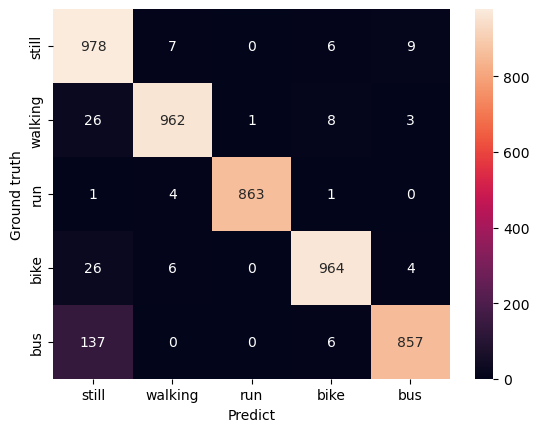

In [79]:
pred_ravel = np.concatenate(list(map(lambda x: x.numpy(), pred)))
gt_ravel = np.concatenate(list(map(lambda x: x.numpy(), gt)))

accuracy = accuracy_score(gt_ravel, pred_ravel)
print("Accuracy", accuracy)

f1 = f1=f1_score(gt_ravel, pred_ravel, average="macro")
print("F1", f1)

cf = confusion_matrix(gt_ravel, pred_ravel)

print(cf)
label_list = ["still", "walking", "run", "bike", "bus"]
s = sns.heatmap(cf, annot=True, fmt='g')
s.set(xlabel="Predict", ylabel="Ground truth", xticklabels=label_list, yticklabels=label_list)